In [1]:
!curl http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip -o pokemon.zip #downloading zip file

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M  100  114M    0     0  40.3M      0  0:00:02  0:00:02 --:--:-- 40.3M


In [2]:
!unzip pokemon.zip -d /kaggle/working/  # unzipping it


Archive:  pokemon.zip
   creating: /kaggle/working/pokemon/
   creating: /kaggle/working/pokemon/692/
 extracting: /kaggle/working/pokemon/692/692-16.png  
 extracting: /kaggle/working/pokemon/692/692-21.png  
 extracting: /kaggle/working/pokemon/692/692-8.png  
 extracting: /kaggle/working/pokemon/692/692-36.png  
 extracting: /kaggle/working/pokemon/692/692-14.png  
 extracting: /kaggle/working/pokemon/692/692-19.png  
 extracting: /kaggle/working/pokemon/692/692-6.png  
 extracting: /kaggle/working/pokemon/692/692-0.png  
 extracting: /kaggle/working/pokemon/692/692-7.png  
 extracting: /kaggle/working/pokemon/692/692-12.png  
 extracting: /kaggle/working/pokemon/692/692-26.png  
 extracting: /kaggle/working/pokemon/692/692-30.png  
 extracting: /kaggle/working/pokemon/692/692-4.png  
 extracting: /kaggle/working/pokemon/692/692-32.png  
 extracting: /kaggle/working/pokemon/692/692-13.png  
 extracting: /kaggle/working/pokemon/692/692-20.png  
 extracting: /kaggle/working/pokemon/69

In [3]:
# importing necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn

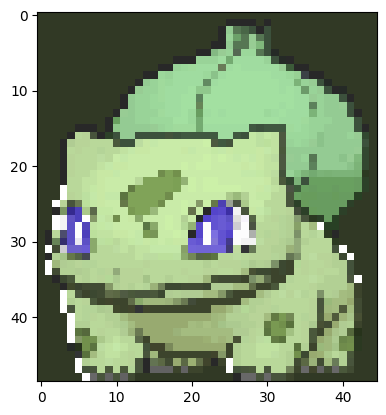

In [4]:
# checking how the images are
img= cv2.imread('/kaggle/working/pokemon/1/1-0.png')
plt.imshow(img)
plt.show()

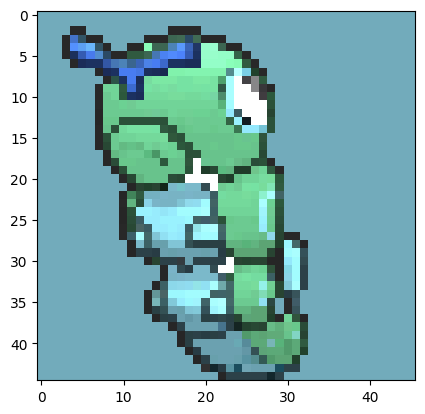

In [5]:
img= cv2.imread('/kaggle/working/pokemon/10/10-0.png')
plt.imshow(img)
plt.show()

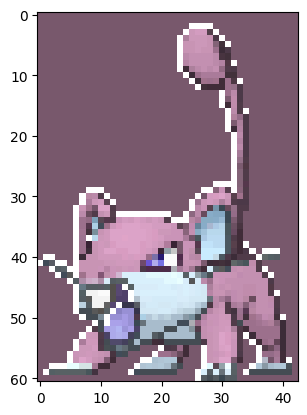

In [6]:
img= cv2.imread('/kaggle/working/pokemon/19/19-0.png')
plt.imshow(img)
plt.show()

In [7]:
# some preprocessing
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),   # they did not have same shapes so making all of them of a same shape
    torchvision.transforms.ToTensor(),# converting them to tensor
    torchvision.transforms.Normalize((0.5,), (0.5,))  # normalizing them so that they match the output of tanh function i.e. -1 to 1
])
pokemons= torchvision.datasets.ImageFolder(root='/kaggle/working/pokemon',transform=transformer)  # loades the image data by opening each image as a pil image from the directory with a structurehaving each class having their own directory

In [8]:
img.shape #image shape earlier

(61, 43, 3)

In [9]:
next(iter(pokemons))[0].shape  #image shape now


torch.Size([3, 64, 64])

In [10]:
pokemons  # can see the total number of images

Dataset ImageFolder
    Number of datapoints: 40597
    Root location: /kaggle/working/pokemon
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [11]:
bs =256 # setting my batch size

In [12]:
data = torch.utils.data.DataLoader(pokemons, batch_size=bs, shuffle=True)  # this shuffles the data and divide them into batches

In [13]:
next(iter(data))[1] # labels that we do not need

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor([551, 365, 446, 165, 203, 719, 136,  64, 617, 128, 650, 679, 362,  69,
        250, 465, 669, 548, 242, 432, 230,  27, 462, 321, 710, 162, 201, 617,
        517, 598, 478, 205, 458, 425, 481, 441, 475, 235, 439, 169, 398, 715,
        711, 430, 548, 271, 290, 652, 531, 135, 350,  97, 177, 493, 489, 139,
        570, 579, 451, 720, 132, 143, 510,  18,  13,  57, 571, 716, 681,  61,
         19, 331,  54,  85, 435, 559,  52,  33, 700, 366, 317, 187, 104, 126,
        186, 313, 451, 257, 416, 541, 170, 215, 315, 677, 416, 102, 617, 426,
        551, 587,  50, 406, 545, 303, 393, 108, 597, 155,  79, 435, 678, 250,
        126, 461, 210, 252,  71, 512, 562, 570, 284,  64, 157, 650, 657, 581,
        273, 554, 294, 208, 289, 605, 178, 541, 561, 115, 135,  70, 570, 308,
        568, 689, 154, 616, 206, 136, 217,  98, 502, 427, 276, 116, 114, 536,
        306, 342, 650, 568, 268, 390, 295,  99, 247, 103, 703, 675, 444, 720,
        639, 161, 124, 272,  38, 604,  84, 381, 619, 135, 181, 1

In [14]:
next(iter(data))[0].shape     # shape of our batches

torch.Size([256, 3, 64, 64])

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # defining my gpu here if available

In [16]:
print(device)  

cuda


In [17]:
# making a function to generate random noise that will be our input
def generate_noise(batch_size=bs, dim=100):
    return torch.normal(0, 1, size=(batch_size,dim, 1, 1)).to(device)   # setting mean and std. deviation  = 0 and 1 respectively

In [18]:
# making generator class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv0 = nn.ConvTranspose2d(100, 512, 4, 2, 0, bias=False)
        self.norm0 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU()                                                                       

        self.conv1=nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2,bias=False, padding=1)
        self.norm1= nn.BatchNorm2d(256)

        self.conv2=nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2,bias=False, padding=1)
        self.norm2= nn.BatchNorm2d(128)


        self.conv3=nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2,bias=False, padding=1)
        self.norm3= nn.BatchNorm2d(64)


        self.conv4=nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2,bias=False, padding=1)
        self.tanh= nn.Tanh()

    def forward(self, x):
        x= self.conv0(x)
        x = self.norm0(x)
        x = self.relu(x)   # 256,512,4,4
        x = self.conv1(x)  
        x = self.norm1(x)
        x= self.relu(x)    # 256,256,8,8
        x = self.conv2(x)
        x=self.norm2(x)
        x=self.relu(x)    # 256,128,16,16
        x = self.conv3(x)
        x=self.norm3(x)
        x=self.relu(x)    # 256,64,32,32
        x = self.conv4(x) # 256,3,64,64
        x=self.tanh(x)
        return x


In [19]:
# just checking out the output shape for debugging
sample_noise= generate_noise()
generator= Generator().to(device)
fake_images= generator(sample_noise)
fake_images.shape

torch.Size([256, 3, 64, 64])

In [20]:
# making discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.machine=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, bias=False)

        )
    def forward(self,x):
        return self.machine(x)


In [21]:
# checing the output shape of my discriminator
q=next(iter(data))[0] .to(device)
discriminator= Discriminator().to(device)
discriminator(q).shape

torch.Size([256, 1, 1, 1])

In [22]:
num_epochs =20  # setting number of epochs                       

In [23]:
# initializing my weights to have mean 0 and variance 0.02 as given in the DCGAN paper
def weights_init(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d or type(m) == nn.BatchNorm2d:
      nn.init.normal_(m.weight, 0.0, 0.02)

In [24]:
discriminator.apply(weights_init)
generator.apply(weights_init)


Generator(
  (conv0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
  (norm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)

In [25]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))  # optimizing using Adam and setting learning rate = 0.0002 and beta1 value = 0.5 as given by paper
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [26]:
l = nn.BCEWithLogitsLoss()   # using this loss as it automatically applies sigmoid to the last layer ouput's of my discriminator


In [32]:
# defining my training loop
for i in range(num_epochs):
    loss_D,loss_G = 0,0
    loss_real,loss_fake=0,0

    for real_images,_ in data:

        # training the discriminator

        real_images= real_images.to(device)
        noise= generate_noise(batch_size=real_images.shape[0])      #generating noise
        bs=noise.shape[0]                                                  
        ones = torch.ones(bs, device=device)                                  
        zeros = torch.zeros(bs, device=device)

        fake_images= generator(noise)                              # fake image generated by the generator from the noise

        real_pred= discriminator(real_images).view(-1)           # passing the real image to the discriminator
        loss_real= l(real_pred, ones)                        # calculating loss of discriminator on real images

        fake_pred= discriminator(fake_images.detach()).view(-1)     # passing the fake images through the discriminator while detaching generator so that its weight are not changed

        loss_fake= l(fake_pred, zeros)                           # calculating loss of discriminator on fae images

        loss_D= (loss_real + loss_fake) / 2                              # averaging both losses
        
        # backward pass
        optimizer_D.zero_grad()                           
        loss_D.backward()

        #updates weights
        optimizer_D.step()

         # training the generator 

        fake_pred= discriminator(fake_images).view(-1)                #again passing the fake image to the discriminator after updating its weight
        loss_G= l(fake_pred, ones)                                   #telling the discriminator that the fake images generated by generator are real
        
        # backward pass only to the generator
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()


    print('Epoch [{}/{}], Disc_LOSS: {:.4f},GEN_LOSS: {:.4f}'.format(i+1, num_epochs, loss_D.item(),loss_G.item()))

    # saving the images after every epoch
    with torch.no_grad():
        noise = generate_noise(batch_size=5)
        generated_imgs = generator(noise)
        generated_imgs = ((generated_imgs + 1) / 2)   # getting image in range 0 to 1 
        torchvision.utils.save_image(generated_imgs, 'generated_image_epoch_{}.png'.format(i+1))




Epoch [1/20], Disc_LOSS: 0.0256,GEN_LOSS: 4.5994
Epoch [2/20], Disc_LOSS: 0.0174,GEN_LOSS: 4.9980
Epoch [3/20], Disc_LOSS: 0.2527,GEN_LOSS: 2.4734
Epoch [4/20], Disc_LOSS: 0.1447,GEN_LOSS: 3.2920
Epoch [5/20], Disc_LOSS: 0.1957,GEN_LOSS: 2.9619
Epoch [6/20], Disc_LOSS: 0.1488,GEN_LOSS: 2.8793
Epoch [7/20], Disc_LOSS: 0.1826,GEN_LOSS: 3.5530
Epoch [8/20], Disc_LOSS: 0.5287,GEN_LOSS: 2.6491
Epoch [9/20], Disc_LOSS: 0.1973,GEN_LOSS: 2.7490
Epoch [10/20], Disc_LOSS: 0.1628,GEN_LOSS: 2.9965
Epoch [11/20], Disc_LOSS: 0.1194,GEN_LOSS: 2.3262
Epoch [12/20], Disc_LOSS: 0.2749,GEN_LOSS: 1.7608
Epoch [13/20], Disc_LOSS: 0.2118,GEN_LOSS: 2.4517
Epoch [14/20], Disc_LOSS: 0.1809,GEN_LOSS: 2.7507
Epoch [15/20], Disc_LOSS: 0.1907,GEN_LOSS: 3.5172
Epoch [16/20], Disc_LOSS: 0.2104,GEN_LOSS: 2.6416
Epoch [17/20], Disc_LOSS: 0.2166,GEN_LOSS: 3.1031
Epoch [18/20], Disc_LOSS: 0.1704,GEN_LOSS: 2.9104
Epoch [19/20], Disc_LOSS: 0.2204,GEN_LOSS: 4.0752
Epoch [20/20], Disc_LOSS: 0.1470,GEN_LOSS: 3.7060


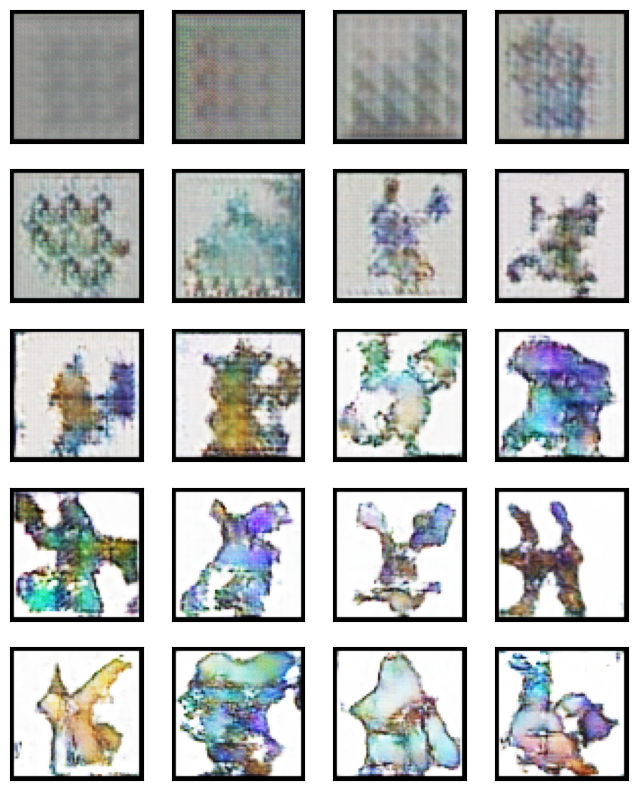

In [44]:
# results after every epoch

figsize = (4 * 2, 5 * 2)
_, axes = plt.subplots(5, 4, figsize=figsize)
for i in range(5):
    for j in range(4):
        img = cv2.imread(f'/kaggle/working/generated_image_epoch_{i*4+j+1}.png')
        img=img[:,:68]
        axes[i, j].imshow(img)
        axes[i, j].axes.get_xaxis().set_visible(False)
        axes[i, j].axes.get_yaxis().set_visible(False)

In [33]:
# function to predict by generating a random noise
def predict():
  pred= generator(generate_noise())
  p=pred[0].view(3,64,64)
  p=p.cpu().detach().numpy()
  p=p.transpose(1,2,0)
  p= p+1
  p= p/2
  p= p*255
  p = p.astype(np.uint8)
  plt.imshow(p)

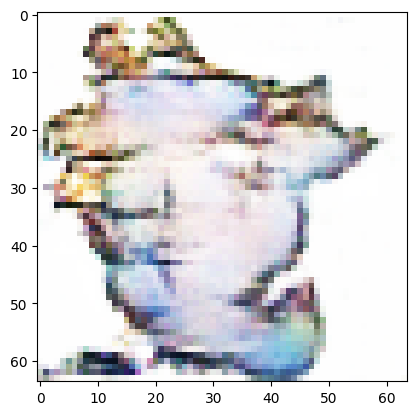

In [37]:
predict()

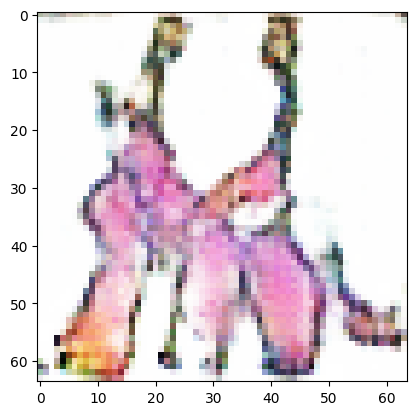

In [38]:
predict()